In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
import pickle
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
import seaborn as sb
import IO
from sklearn import linear_model
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from collections import OrderedDict

def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject

def get_coeff(loc_="ECOG", mod_="CON", return_per=False):
    res_ = []
    per_sub = []
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        sess  = [f for f in os.listdir(settings["out_path_process"]) if (loc_ in f) \
                 and settings["num_patients"][sub_idx] in f] 
        per_ = []; coef_ = []
        for sess_ in sess:
            dat = np.load(os.path.join(settings["out_path_process"], sess_), allow_pickle=True).tolist()
            per_.append(dat["score_te"][mod_])
            coef_.append(dat["coef"][mod_])
        coef_ = np.concatenate(coef_)
        res_.append(coef_[np.argmax(np.concatenate(per_))])
        per_sub.append(np.max(np.concatenate(per_)))
    if return_per:
        return np.array(res_), np.array(per_sub)
    return np.array(res_)

In [2]:
settings = {}
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
settings['BIDS_path'] = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH"
settings['out_path'] = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data\Int_old_grid"
settings['out_path_process'] = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\Features_ind_channels'

In [3]:
# here: read every .p file and use LM's only for individual time points and f-bands 

In [4]:
laterality=[("CON"), ("IPS")]
signal=["STN", "ECOG"]

for signal_idx, signal_ in enumerate(signal):
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        subject_path=settings['BIDS_path'] + '\\sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)
        for sess_idx in range(len(subfolder)):
            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)
            if signal_ == "ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)
                    
            for run_idx in range(len(list_subject)):
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)
                #concatenate features
                if signal_=="ECOG":
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            #gc.collect() # free unreferenced memory

            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            label_= OrderedDict()
            sc_te= OrderedDict()
            Model_coef= OrderedDict()

            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_te[laterality_] = []
                Model_coef[laterality_] = []
                label_[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_te=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                y = np.empty(X.shape[1],dtype=object)

                #for each electrod
                for ch_idx in range(X.shape[1]):
                    # rechne hier die CV 
                    # wir sind nur an mean test performance interessiert 
                    # und wichtig, wir wollen weights plotten, getrennt für verschiedene Zeitschritte 

                    # dafür isst aber erstmal wichtig die LM R^2 performance CV rauszukriegen
                    # und zwar ohne Time Concatenation! 

                    sc_ = np.nanmean(cross_val_score(linear_model.LinearRegression(), 
                                            X[:, ch_idx, :], label, scoring="r2", cv=5))
                    if sc_ < 0: sc_ = 0             

                    Score_te[ch_idx] = sc_
                    COEF_[ch_idx] = linear_model.Lasso(alpha=0.001).fit(X[:, ch_idx, :], label).coef_
                    y[ch_idx] = label
                    
                sc_te[laterality_] = Score_te
                Model_coef[laterality_] = COEF_
                label_[laterality_] = y
                
            predict_ = {
                "score_te": sc_te,
                "coef" :Model_coef, 
                "X":X,
                "y":label_
            }
            out_path_file = os.path.join(settings['out_path_process']+ "\\" + \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-EphysMedOn01
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-EphysMedOn01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_S

In [5]:
# transform data to dataframe 
fbs = [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$']
df_linear_model = pd.DataFrame()
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        data_, per = get_coeff(loc_=loc, mod_=lat, return_per=True)
        for patient in range(11):
            for f_band in range(8):
                df_linear_model = df_linear_model.append({
                    "Frequency bands":fbs[f_band],
                    "patient":patient,
                    "Weights":data_[patient,f_band],
                    "loc":loc,
                    "lat":lat,
                    "per" : per
                },ignore_index=True)

In [6]:
laterality=[("CON"), ("IPS")]
signal=["STN", "ECOG"]

for signal_idx, signal_ in enumerate(signal):
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        subject_path=settings['BIDS_path'] + '\\sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)
        for sess_idx in range(len(subfolder)):
            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)
            if signal_ == "ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)
                    
            for run_idx in range(len(list_subject)):
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)
                #concatenate features
                if signal_=="ECOG":
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            #gc.collect() # free unreferenced memory

            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            label_= OrderedDict()
            sc_te= OrderedDict()
            Model_coef= OrderedDict()

            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_te[laterality_] = []
                Model_coef[laterality_] = []
                label_[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_te=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                y = np.empty(X.shape[1],dtype=object)

                #for each electrod
                for ch_idx in range(X.shape[1]):
                    # rechne hier die CV 
                    # wir sind nur an mean test performance interessiert 
                    # und wichtig, wir wollen weights plotten, getrennt für verschiedene Zeitschritte 

                    # dafür isst aber erstmal wichtig die LM R^2 performance CV rauszukriegen
                    # und zwar ohne Time Concatenation! 

                    sc_ = np.nanmean(cross_val_score(linear_model.Lasso(alpha=0.02), 
                                            X[:, ch_idx, :], label, scoring="r2", cv=5))
                    if sc_ < 0: sc_ = 0             

                    Score_te[ch_idx] = sc_
                    COEF_[ch_idx] = linear_model.Lasso(alpha=0.001).fit(X[:, ch_idx, :], label).coef_
                    y[ch_idx] = label
                    
                sc_te[laterality_] = Score_te
                Model_coef[laterality_] = COEF_
                label_[laterality_] = y
                
            predict_ = {
                "score_te": sc_te,
                "coef" :Model_coef, 
                "X":X,
                "y":label_
            }
            out_path_file = os.path.join(settings['out_path_process']+ "\\" + \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-EphysMedOn01
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-EphysMedOn01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-EphysMedOff01
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-EphysMedOff01_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_S

In [7]:
# transform data to dataframe 
fbs = [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$']
df_lasso = pd.DataFrame()
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        data_, per = get_coeff(loc_=loc, mod_=lat, return_per=True)
        for patient in range(11):
            for f_band in range(8):
                df_lasso = df_lasso.append({
                    "Frequency bands":fbs[f_band],
                    "patient":patient,
                    "Weights":data_[patient,f_band],
                    "loc":loc,
                    "lat":lat,
                    "per" : per
                },ignore_index=True)

In [8]:
#1. compare performances of linear model and lasso

In [9]:
df_lasso.iloc[0]["per"]

array([0.31632482, 0.24951104, 0.06229873, 0.05300439, 0.17353526,
       0.04049534, 0.00851787, 0.01096874, 0.14332633, 0.02451203,
       0.03985376])

In [10]:
df_linear_model["per"].iloc[0]

array([0.33785163, 0.29922406, 0.07239909, 0.08246858, 0.21753415,
       0.07038308, 0.16283004, 0.04397753, 0.19321918, 0.06056773,
       0.05731625])

In [11]:
df_per_comp_per = pd.DataFrame()
for sub in range(11):
    df_per_comp_per = df_per_comp_per.append(
        {
            "sub" : sub,
            "r2" : df_linear_model["per"].iloc[0][sub],
            "model" : "lm_no_reg"
        },
        ignore_index=True
    )
    
    df_per_comp_per = df_per_comp_per.append(
        {
            "sub" : sub,
            "r2" : df_lasso["per"].iloc[0][sub],
            "model" : "lasso_reg"
        },
        ignore_index=True
    )
    

In [18]:
df_per_comp_per['model'] = df_per_comp_per['model'].replace({'lm_no_reg': 'no regulariation', 'lasso_reg': 'lasso'})

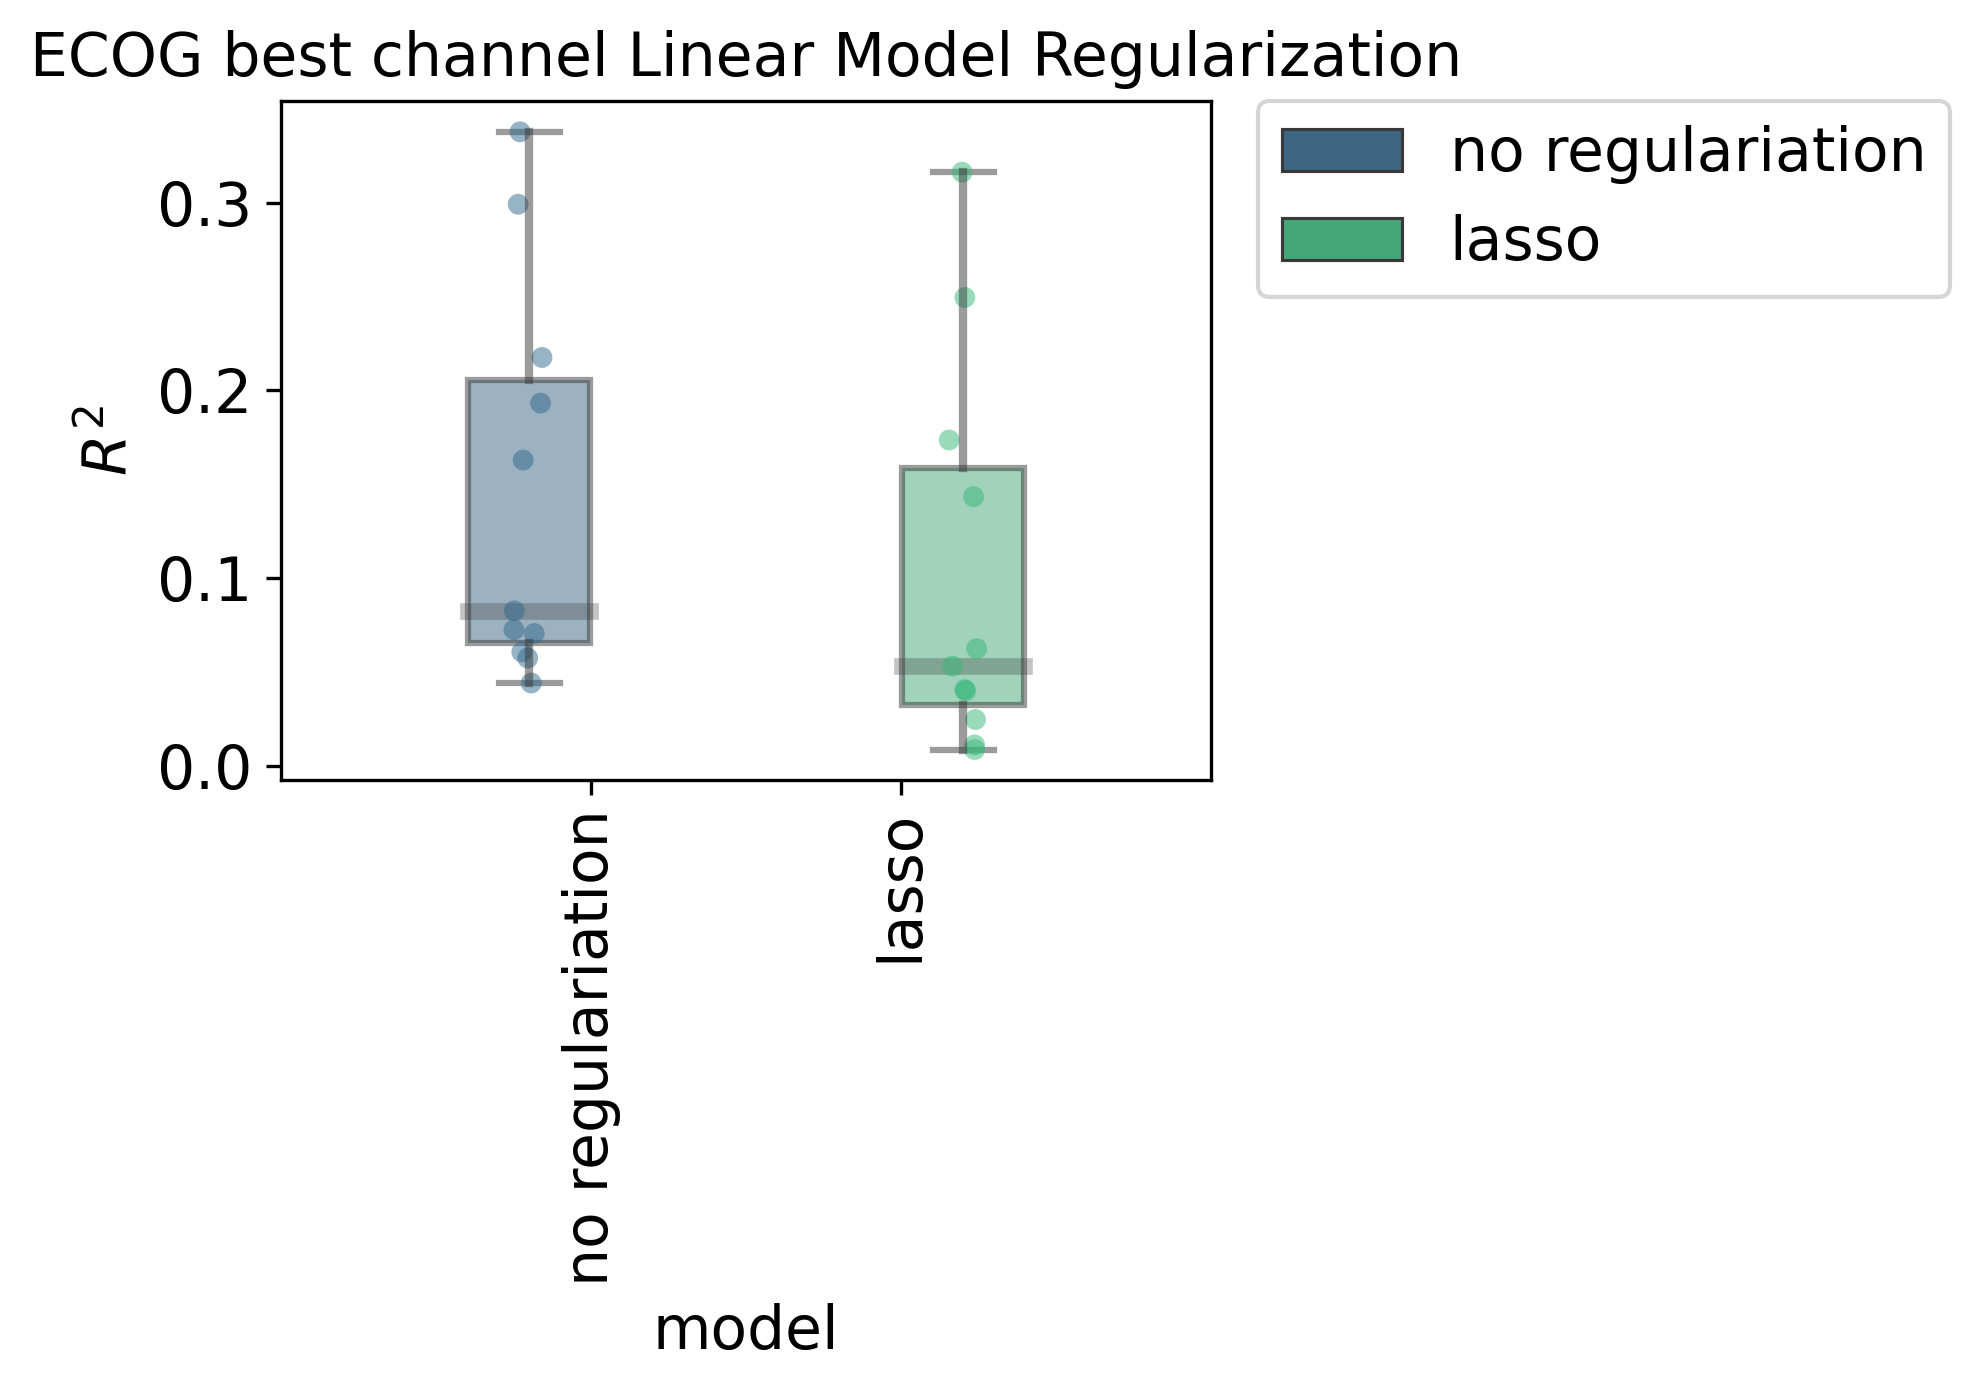

In [24]:
alpha_box=0.5
plt.figure(figsize=(4,3), dpi=300)
ax = sb.boxplot(x="model", y="r2", hue="model", 
           data=df_per_comp_per, palette="viridis",
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-', linewidth=4, alpha=0.3)) 
ax = sb.stripplot(x="model", y="r2", hue="model", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df_per_comp_per, palette="viridis", dodge=True, s=5, alpha=alpha_box)
val = 1
ax.set_xlim(0-val, 1+val)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG best channel Linear Model Regularization")
plt.ylabel(r"$R^2$")
plt.xticks(rotation=90)
plt.savefig("Point 6 - LASSO Performance Effect.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [13]:
df_lasso

,Frequency bands,patient,Weights,loc,lat,per
0,$\theta$,0.0,-0.006271,ECOG,CON,"[0.31632482217854496, 0.24951103973774905, 0.0..."
1,$\alpha$,0.0,-0.012145,ECOG,CON,"[0.31632482217854496, 0.24951103973774905, 0.0..."
2,$l\beta$,0.0,-0.002548,ECOG,CON,"[0.31632482217854496, 0.24951103973774905, 0.0..."
3,$h\beta$,0.0,-0.036147,ECOG,CON,"[0.31632482217854496, 0.24951103973774905, 0.0..."
4,$a\beta$,0.0,-0.000000,ECOG,CON,"[0.31632482217854496, 0.24951103973774905, 0.0..."
...,...,...,...,...,...,...
347,$h\beta$,10.0,-0.020994,STN,IPS,"[0.049010220680473116, 0.051326996023496996, 0..."
348,$a\beta$,10.0,-0.019914,STN,IPS,"[0.049010220680473116, 0.051326996023496996, 0..."
349,$l\gamma$,10.0,-0.001239,STN,IPS,"[0.049010220680473116, 0.051326996023496996, 0..."
350,$HFA$,10.0,-0.000000,STN,IPS,"[0.049010220680473116, 0.051326996023496996, 0..."


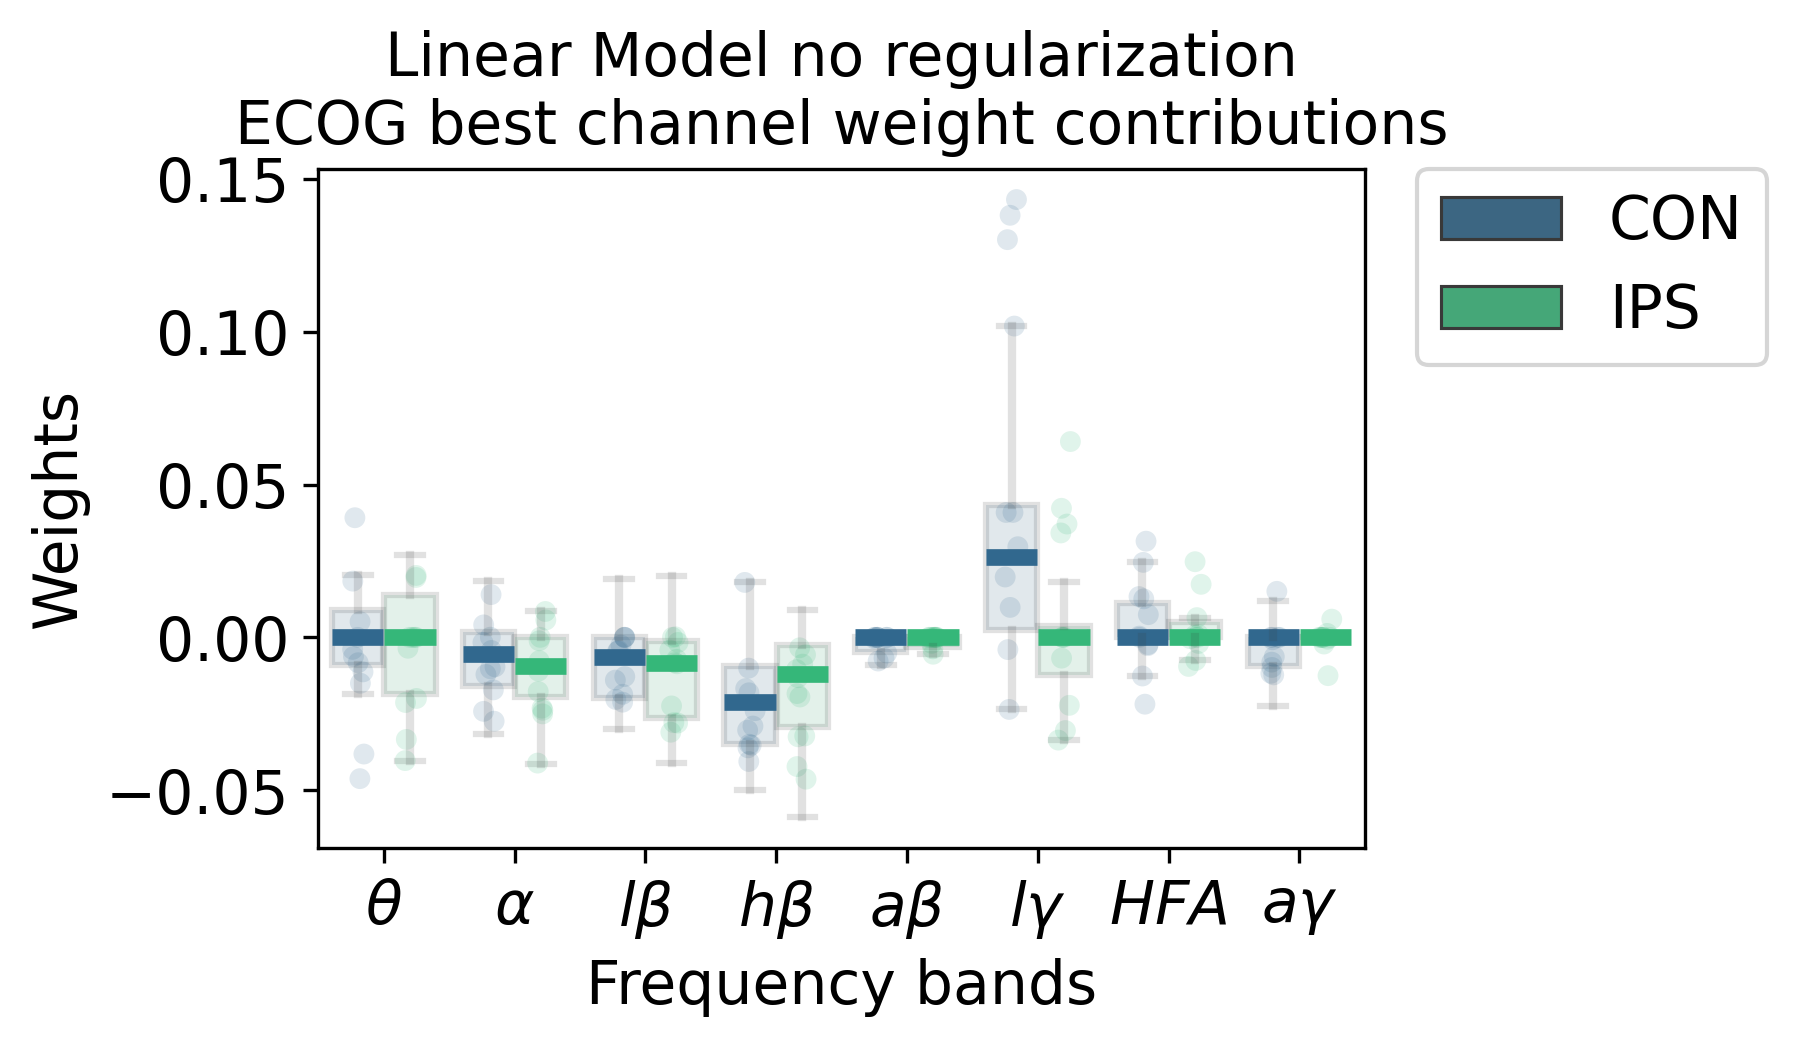

In [25]:
df = df_linear_model
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

alpha_box = 0.15
alpha_median = 1
plt.figure(figsize=(4.5,3), dpi=300)
ax = sb.boxplot(x="Frequency bands", y="Weights", hue="lat", 
           data=df, palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=4, alpha=0.0124))# , color="gray"

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))

hue_colors = sb.color_palette("viridis", df["lat"].unique().shape[0])
switch_ = 0
for line in ax.lines:
    if line.get_alpha() == 0.0124:
        
        line.set_color(hue_colors[switch_])
        switch_ += 1
        
        if switch_ >= len(hue_colors):
            switch_ = 0
            
        line.set_alpha(alpha_median)
        
ax = sb.stripplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5, alpha=alpha_box)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Linear Model no regularization\nECOG best channel weight contributions")
plt.savefig("Point 6 - Linear Model NoReg weights.pdf", bbox_inches='tight', dpi=300)
plt.show()

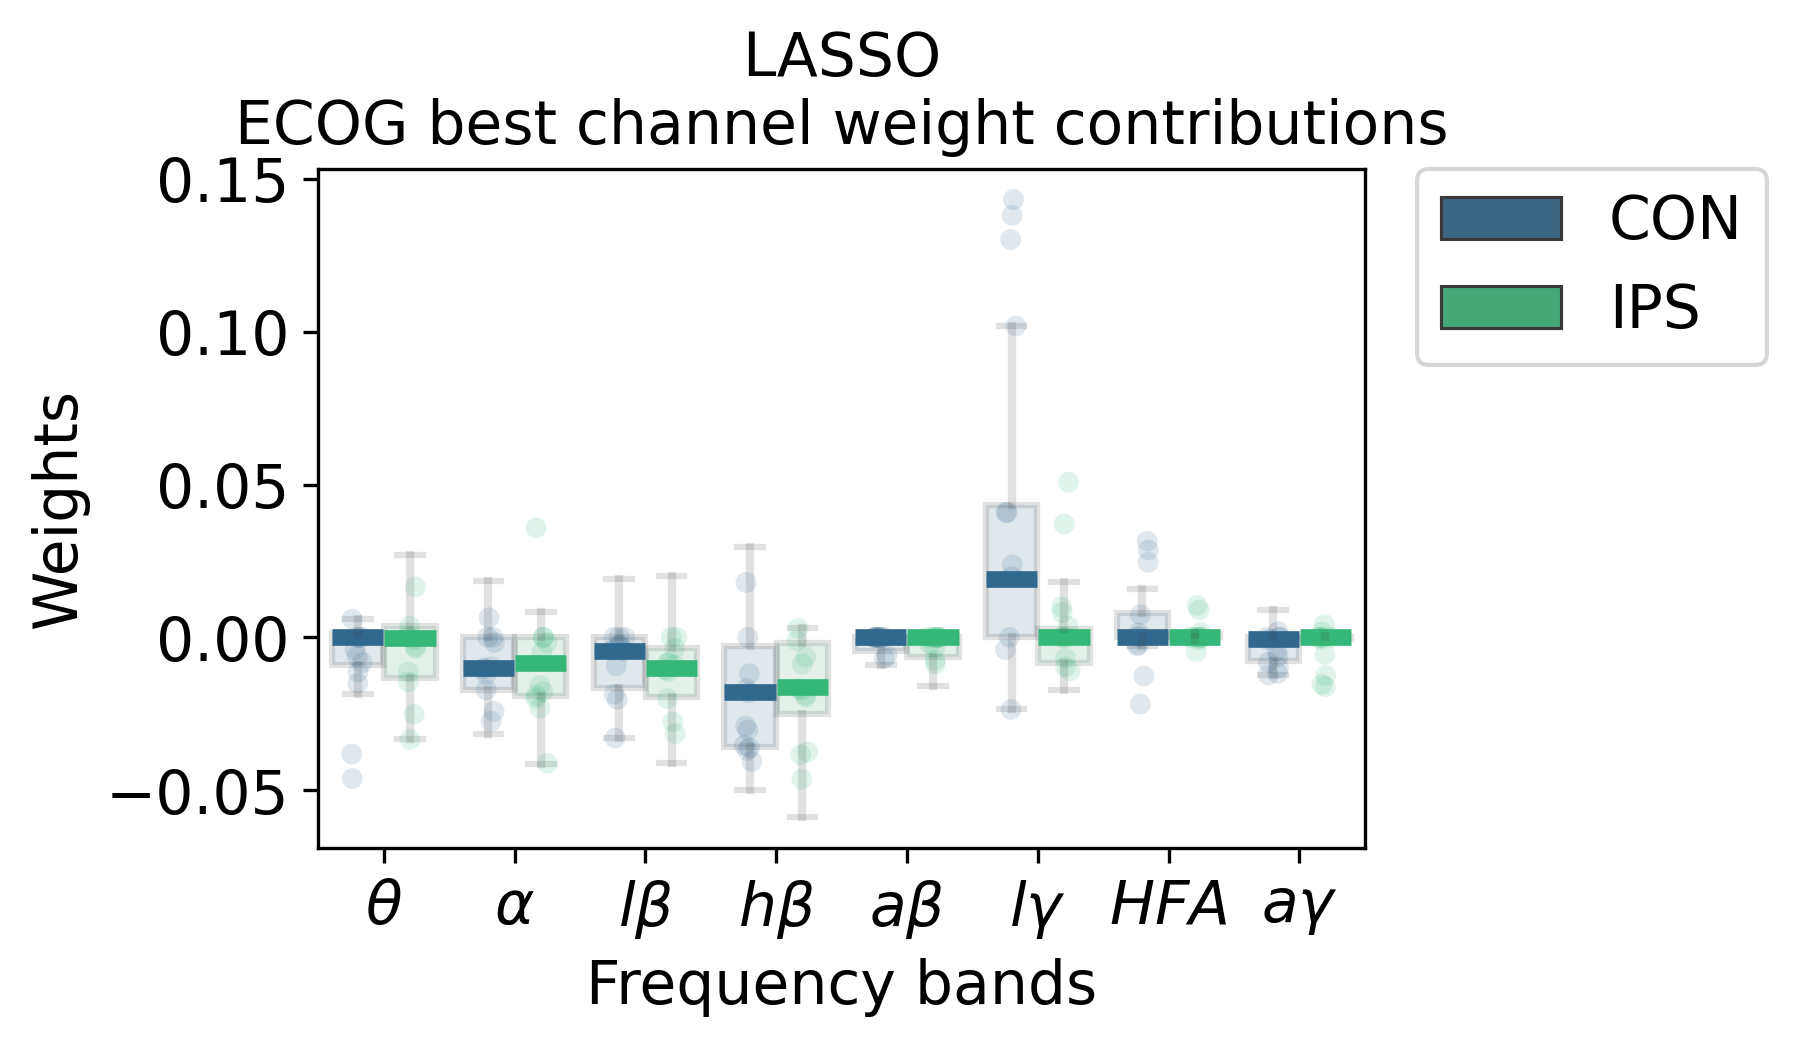

In [26]:
df = df_lasso
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

alpha_box = 0.15
alpha_median = 1
plt.figure(figsize=(4.5,3), dpi=300)
ax = sb.boxplot(x="Frequency bands", y="Weights", hue="lat", 
           data=df, palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=4, alpha=0.0124))# , color="gray"

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))

hue_colors = sb.color_palette("viridis", df["lat"].unique().shape[0])
switch_ = 0
for line in ax.lines:
    if line.get_alpha() == 0.0124:
        
        line.set_color(hue_colors[switch_])
        switch_ += 1
        
        if switch_ >= len(hue_colors):
            switch_ = 0
            
        line.set_alpha(alpha_median)
        
ax = sb.stripplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5, alpha=alpha_box)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("LASSO\nECOG best channel weight contributions")
plt.savefig("Point 6 - Lasso Weights.pdf", bbox_inches='tight', dpi=300)
plt.show()